In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import sqlite3
from transformers import pipeline

# for tracking time
from tqdm import tqdm
tqdm.pandas()

# Graphics and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import textwrap
from tabulate import tabulate

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression


from sklearn.svm import SVR
from sklearn.svm import LinearSVR
# deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Dense, SpatialDropout1D, Dropout, BatchNormalization, concatenate, Bidirectional
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.callbacks import EarlyStopping

from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.layers import Input, Dense, concatenate, Embedding, SpatialDropout1D, LSTM, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences




# Text processing
import re
import string
from textblob import TextBlob
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")
from sklearn.feature_extraction.text import TfidfVectorizer


# evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Step 0: Load Models

In [2]:
X_train = pd.read_pickle("./data/X_train.pkl")
y_train = pd.read_pickle("./data/y_train.pkl")
X_test = pd.read_pickle("./data/X_test.pkl")
y_test = pd.read_pickle("./data/y_test.pkl")
df_merged = pd.read_pickle("./data/df_merged.pkl")

In [3]:
# Reset the index of X_train and y_train to ensure alignment
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Reset the index of X_test and y_test to ensure alignment
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Filter y_train to exclude 'undetermined' values
valid_indices_train = y_train[y_train["PostEngagementTopFlop10"] != 'undetermined'].index
X_train = X_train.loc[valid_indices_train]
y_train = y_train.loc[valid_indices_train]

# Filter y_test to exclude 'undetermined' values
valid_indices_test = y_test[y_test["PostEngagementTopFlop10"] != 'undetermined'].index
X_test = X_test.loc[valid_indices_test]
y_test = y_test.loc[valid_indices_test]


In [4]:
def shuffle_and_select_top_n(X, y, stratify_col, top_n=1000, random_state=7):
    """
    Shuffles and selects the top N rows for each class while maintaining stratification.
    
    Args:
        X (pd.DataFrame): Features.
        y (pd.DataFrame): Target labels.
        stratify_col (str): Column name in y for stratification.
        top_n (int): Number of rows to select for each class.
        random_state (int): Random state for reproducibility.
    
    Returns:
        tuple: (X_new, y_new) containing shuffled and stratified top N rows.
    """
    combined = X.copy()
    combined['target'] = y[stratify_col]
    
    # Shuffle and group by the target column, then take the top `n` rows per class
    selected = combined.sample(frac=1, random_state=random_state).groupby('target', group_keys=False).head(top_n)
    
    # Extract features and labels while preserving indices
    X_new = selected.drop(columns=['target'])
    y_new = y.loc[selected.index].reset_index(drop=True)
    
    return X_new, y_new


X_train, y_train = shuffle_and_select_top_n(X_train, y_train, stratify_col='PostEngagementTopFlop25', top_n=20000)
X_test, y_test = shuffle_and_select_top_n(X_test, y_test, stratify_col='PostEngagementTopFlop25', top_n=5000)


In [5]:
y_train["PostEngagementTopFlop10"].value_counts()

regular post     20000
engaging post    20000
Name: PostEngagementTopFlop10, dtype: int64

In [6]:
# Identify non-numeric columns
non_numeric_columns = X_train.select_dtypes(exclude=['number']).columns

# Print non-numeric columns
print("Non-numeric columns in the DataFrame:")
print(non_numeric_columns.to_list())


Non-numeric columns in the DataFrame:
['CreatedAt', 'Headline', 'Body', 'Path', 'publishingDate', 'Title', 'Subtitle', 'FullText', 'CleanedText']


## Step 3: Train & Evaluate Models

In [7]:
y_train_classification = y_train["PostEngagement"]
y_test_classification = y_test["PostEngagement"]

y_train_regression = y_train["TotalVotes"]
y_test_regression = y_test["TotalVotes"]

generated_features_wo_sentiment = [col for col in X_train.columns if col not in {
    "ID_Post", "ID_Parent_Post", "ID_Article", "ID_User", "CreatedAt", "article_post_count",
    "Status", "Headline", "Body", "Path", "publishingDate", "Title", 
    "Subtitle", "FullText",  "CleanedText",  "rank_interval", 'initial_interval',
    "publication_time", "publication_rank", 'publication_rank_interval','level_2'
    "sentiment_score", 
}]

generated_features = [col for col in X_train.columns if col not in {
    "ID_Post", "ID_Parent_Post", "ID_Article", "ID_User", "CreatedAt", "article_post_count",
    "Status", "Headline", "Body", "Path", "publishingDate", "Title", 
    "Subtitle", "FullText", "CleanedText", 'rank_interval', 'initial_interval',
    "publication_time", "publication_rank", 'publication_rank_interval', 'level_2'
}]

# Function to tokenize and pad the textual data
def preprocess_text_column(column, tokenizer=None, max_len=100):
    if tokenizer is None:
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(column)
    
    sequences = tokenizer.texts_to_sequences(column)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding="post")
    
    return padded_sequences, tokenizer

# Preprocess text columns in train and test sets
max_len = 100
X_train_body, body_tokenizer = preprocess_text_column(X_train["Body"], max_len=max_len)
X_test_body = pad_sequences(body_tokenizer.texts_to_sequences(X_test["Body"]), maxlen=max_len, padding="post")

X_train_headline, headline_tokenizer = preprocess_text_column(X_train["Headline"], max_len=max_len)
X_test_headline = pad_sequences(headline_tokenizer.texts_to_sequences(X_test["Headline"]), maxlen=max_len, padding="post")

# Scale temporal features in train and test sets
scaler = StandardScaler()
X_train_temporal = scaler.fit_transform(X_train[["publication_time", "publication_rank"]])
X_test_temporal = scaler.transform(X_test[["publication_time", "publication_rank"]])


# Prepare labels
y_train_classification = (y_train_classification == "engaging post").astype(int)  
y_test_classification = (y_test_classification == "engaging post").astype(int)  


# Ensure all entries are strings and filter out non-string values
def preprocess_text_column(column):
    """Preprocess a text column to ensure all entries are strings."""
    column = column.fillna("").astype(str).tolist()
    return [str(text) for text in column if isinstance(text, str)]

# Apply preprocessing
X_train_body_bert = preprocess_text_column(X_train["Body"])
X_test_body_bert = preprocess_text_column(X_test["Body"])

X_train_headline_bert = preprocess_text_column(X_train["Headline"])
X_test_headline_bert = preprocess_text_column(X_test["Headline"])

# Define BERT input encoding function
def bert_encode_texts(texts, tokenizer, max_length=128):
    """Encode texts using BERT tokenizer."""
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="tf")

# Encode text data for BERT model
X_train_body_encoded_bert = bert_encode_texts(X_train_body_bert, distilbert_tokenizer, max_length=64)
X_test_body_encoded_bert = bert_encode_texts(X_test_body_bert, distilbert_tokenizer, max_length=64)

X_train_headline_encoded_bert = bert_encode_texts(X_train_headline_bert, distilbert_tokenizer, max_length=32)
X_test_headline_encoded_bert = bert_encode_texts(X_test_headline_bert, distilbert_tokenizer, max_length=32)

# Extract input IDs and attention masks for both body and headline texts
X_train_body_ids_bert = X_train_body_encoded_bert["input_ids"]
X_test_body_ids_bert = X_test_body_encoded_bert["input_ids"]
X_train_body_mask_bert = X_train_body_encoded_bert["attention_mask"]
X_test_body_mask_bert = X_test_body_encoded_bert["attention_mask"]

X_train_headline_ids_bert = X_train_headline_encoded_bert["input_ids"]
X_test_headline_ids_bert = X_test_headline_encoded_bert["input_ids"]
X_train_headline_mask_bert = X_train_headline_encoded_bert["attention_mask"]
X_test_headline_mask_bert = X_test_headline_encoded_bert["attention_mask"]

# Pad sequences to ensure consistent shape
X_train_body_ids_bert = pad_sequences(X_train_body_ids_bert, maxlen=64, padding="post")
X_test_body_ids_bert = pad_sequences(X_test_body_ids_bert, maxlen=64, padding="post")
X_train_body_mask_bert = pad_sequences(X_train_body_mask_bert, maxlen=64, padding="post")
X_test_body_mask_bert = pad_sequences(X_test_body_mask_bert, maxlen=64, padding="post")

X_train_headline_ids_bert = pad_sequences(X_train_headline_ids_bert, maxlen=32, padding="post")
X_test_headline_ids_bert = pad_sequences(X_test_headline_ids_bert, maxlen=32, padding="post")
X_train_headline_mask_bert = pad_sequences(X_train_headline_mask_bert, maxlen=32, padding="post")
X_test_headline_mask_bert = pad_sequences(X_test_headline_mask_bert, maxlen=32, padding="post")


# Function to plot and save feature importance
def plot_feature_importances(features, importances, model_name):
    # Sort features by importance and select top 30
    
    #take only the 30 most important - if we have more than 30
    try:
        top_n = 30
        indices = np.argsort(importances)[::-1][:top_n]
        top_features = np.array(features)[indices]
        top_importances = importances[indices]
    except:
        top_features = np.array(features)
        top_importances = importances
    
    # Set a beautiful plot style
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 8))
    plt.barh(top_features, top_importances, color="skyblue", edgecolor="black")
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.xlabel("Relative Importance")
    plt.title(f"Top {top_n} Feature Importances - {model_name}")
    
    # Save plot to a file with the model name
    filename = f"./figures/feature_importances_{model_name}.png"
    plt.savefig(filename, bbox_inches="tight")
    plt.close()  # Close plot to avoid inline display
    
def train_lstm(model, X_train_body, X_train_headline, y):
    # Define the early stopping callback
    early_stopping = EarlyStopping(
        monitor="val_loss",  # Metric to monitor
        patience=2,          # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
        verbose=1            # Verbosity mode
    )
    
    history = model.fit(
        [X_train_body, X_train_headline], y,
        epochs=10,  
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping]  
    )
    
    return model

#### Hyperparameter Search

In [141]:
# Define parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 150, 200],      # Number of trees
    'max_depth': [10, 15, 20, None],      # Depth of the trees
    'min_samples_split': [2, 10, 20],     # Minimum samples to split
    'min_samples_leaf': [1, 5, 10],       # Minimum samples at leaf nodes
    'max_features': [None, 'sqrt', 'log2'],  # Number of features at each split
}

# For RandomForestRegressor
random_forest_regressor = RandomForestRegressor(random_state=42, n_jobs=-1)

# Set up RandomizedSearchCV for RandomForestRegressor
random_search_regressor = RandomizedSearchCV(
    random_forest_regressor,
    param_distributions=param_grid,
    n_iter=10,  # Number of random combinations to try
    cv=3,       # 3-fold cross-validation
    verbose=2,  # To get more information
    random_state=42,
    n_jobs=-1    # Use all processors
)

# Fit the RandomizedSearchCV
random_search_regressor.fit(X_train[generated_features], y_train_classification)

# Get the best hyperparameters for the RandomForestRegressor
best_params_regressor = random_search_regressor.best_params_

# Now update the variables with the best parameters found
n_trees = best_params_regressor['n_estimators']
maxdepth = best_params_regressor['max_depth']
minsamplessplit = best_params_regressor['min_samples_split']
maxsamplesleaf = best_params_regressor['min_samples_leaf']
maxfeatures = best_params_regressor['max_features']

# Now, fit a Random Forest model with these optimized hyperparameters
random_forest_regression = RandomForestRegressor(
    n_estimators=n_trees,
    random_state=42,
    n_jobs=-1,
    max_depth=maxdepth,
    min_samples_split=minsamplessplit,
    min_samples_leaf=maxsamplesleaf,
    max_features=maxfeatures
)

random_forest_regression.fit(X_train[generated_features], y_train_classification)

# Evaluate the model on the test set
y_pred = random_forest_regression.predict(X_test[generated_features])
mae = mean_absolute_error(y_test_classification, y_pred)
print(f"Mean Absolute Error (Regressor): {mae}")

# For RandomForestClassifier
random_forest_classifier = RandomForestClassifier(random_state=42, n_jobs=-1)

# Set up RandomizedSearchCV for RandomForestClassifier
random_search_classifier = RandomizedSearchCV(
    random_forest_classifier,
    param_distributions=param_grid,
    n_iter=10,  # Number of random combinations to try
    cv=3,       # 3-fold cross-validation
    verbose=2,  # To get more information
    random_state=42,
    n_jobs=-1    # Use all processors
)

# Fit the RandomizedSearchCV for the classifier
random_search_classifier.fit(X_train[generated_features], y_train_classification)

# Get the best hyperparameters for the RandomForestClassifier
best_params_classifier = random_search_classifier.best_params_

# Now update the variables with the best parameters found
n_trees_class = best_params_classifier['n_estimators']
maxdepth_class = best_params_classifier['max_depth']
minsamplessplit_class = best_params_classifier['min_samples_split']
maxsamplesleaf_class = best_params_classifier['min_samples_leaf']
maxfeatures_class = best_params_classifier['max_features']

# Now, fit a Random Forest model with these optimized hyperparameters
random_forest_classification = RandomForestClassifier(
    n_estimators=n_trees_class,
    random_state=42,
    n_jobs=-1,
    max_depth=maxdepth_class,
    min_samples_split=minsamplessplit_class,
    min_samples_leaf=maxsamplesleaf_class,
    max_features=maxfeatures_class
)

random_forest_classification.fit(X_train[generated_features], y_train_classification)

# Evaluate the model on the test set
y_pred_class = random_forest_classification.predict(X_test[generated_features])
accuracy = accuracy_score(y_test_classification, y_pred_class)
print(f"Accuracy (Classifier): {accuracy}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\user\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
9 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\user\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_paramete

Mean Absolute Error (Regressor): 0.4531667282854593
Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\user\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
9 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\user\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_paramete

Accuracy (Classifier): 0.6445


In [143]:
print(n_trees, maxdepth, minsamplessplit, maxsamplesleaf, maxfeatures)

100 20 2 5 auto


#### Define interpreatable models

In [8]:
# Calculate class distribution
class_counts = np.bincount(y_train_classification)
total_samples = len(y_train_classification)
class_weight_dict = {1: (total_samples / class_counts[0])  , 0: (total_samples / class_counts[1]) }


n_trees = 100
maxdepth = 20 
minsamplessplit = 2
maxsamplesleaf = 5
maxfeatures='log2'

random_forest_regression = RandomForestRegressor(
                n_estimators=n_trees,      # Number of trees
                random_state=42,       
                n_jobs=-1,             # Use all processors
                max_depth=maxdepth,          # Limit depth to avoid overfitting
                min_samples_split=minsamplessplit,  # the number of samples required to split
                min_samples_leaf=maxsamplesleaf,    # the number of samples required at leaves
                max_features=maxfeatures    # The number of features at each split
            )

random_forest_classification = RandomForestClassifier(
                n_estimators=n_trees,      # Number of trees
                random_state=42,       
                n_jobs=-1,             # Use all processors
                #max_depth=maxdepth,          # Limit depth to avoid overfitting
                min_samples_split=minsamplessplit,  # the number of samples required to split
                min_samples_leaf=maxsamplesleaf,    # the number of samples required at leaves
                #max_features=maxfeatures,    # The number of features at each split
                class_weight=class_weight_dict
            )

# Define k-Nearest Neighbors Regressor
knn_regression = KNeighborsRegressor(
    n_neighbors=7,               # Number of neighbors
    weights="uniform",           # Weight function ("uniform" or "distance")
    algorithm="kd_tree",         # Algorithm used to compute neighbors, e.g., "auto", "ball_tree", "kd_tree", "brute"
    leaf_size=50,                # Leaf size for BallTree or KDTree
    p=2                          # Power parameter for the Minkowski metric (1=Manhattan, 2=Euclidean)
)

# Define k-Nearest Neighbors Classifier
knn_classification = KNeighborsClassifier(
    n_neighbors=7,               # Number of neighbors
    weights="uniform",           # Weight function ("uniform" or "distance")
    algorithm="kd_tree",         # Algorithm used to compute neighbors
    leaf_size=50,                # Leaf size for BallTree or KDTree
    p=2                          # Power parameter for the Minkowski metric
)


# Define Decision Tree Classifier
dt_classification = DecisionTreeClassifier(
    criterion="entropy",          # Criterion to measure quality of split ("gini" or "entropy")
    splitter="best",           # Split strategy ("best" or "random")
    max_depth=None,            # Max depth of the tree
    min_samples_split=6,       # Minimum samples to split an internal node
    min_samples_leaf=3         # Minimum samples at a leaf node
)

# Define Decision Tree Classifier
dt_regression = DecisionTreeRegressor(
    criterion="squared_error",  # Criterion to measure quality of split
    splitter="best",            # Split strategy ("best" or "random")
    max_depth=None,             # Max depth of the tree
    min_samples_split=2,        # Minimum samples to split an internal node
    min_samples_leaf=1          # Minimum samples at a leaf node
)

# Define Logistic Regression Classifier
logistic_regression = LogisticRegression(
    penalty="l2",                   # Regularization (L2 is Ridge Regression for Logistic Regression)
    C=1.0,                          # Inverse of regularization strength
    solver="lbfgs",                 # Optimization algorithm
    max_iter=1000,                  # Maximum number of iterations
    class_weight=class_weight_dict, # Handle imbalanced classes
    random_state=42                 # Ensure reproducibility
)


# Define the training function with RandomForestRegressor
def train_explainable_model(features, y_train, model_name, regression=True):


    if regression:
        if "randomforest" in model_name.lower():
            model = random_forest_regression
        elif "decisiontree" in model_name.lower():
            model = dt_regression
        elif "knn" in model_name.lower():
            model = knn_regression
    else:
        if "randomforest" in model_name.lower():
            model = random_forest_classification 
        elif "decisiontree" in model_name.lower():
            model = dt_classification 
        elif "knn" in model_name.lower():
            model = knn_classification
        elif "logistic" in model_name.lower():
            model = logistic_regression
    
    
    # Wrap the model fitting in tqdm to track progress
    if hasattr(model, "n_estimators"):
        for _ in tqdm(range(model.n_estimators), desc="Training " + model_name):
            model.fit(X_train[features], y_train)  # Training step
    else:
        with tqdm(total=1, desc="Training "+ model_name) as pbar:
            model.fit(X_train[features], y_train)
            pbar.update(1)
        
    # Feature importances (for tree-based models only)
    feature_importances = None
    if hasattr(model, "feature_importances_"):
        feature_importances = model.feature_importances_
    
    return model, feature_importances


### Step 3.1: Classification Task

In [9]:
classification_models = {
    "Baseline Classification": y_train_regression.mode(), 
    #"DecisionTree": generated_features,
    #"KNN": generated_features,
    #"M1 RandomForest Shallow Features": ["CharCount",  'WordCount',
     #                                    'UniqueWords','CharCount','PunctCount','SentCount'],
   # "M2 RandomForest Complex Features": generated_features_wo_sentiment,
   #"Logistic Regression Complex": generated_features,
    "Logistic Regression": ["CharCount"],
    #"M3 RandomForest CF + Sentiment": generated_features,
}

### Define Deeplearning models

In [68]:
# Define hyperparameters
embedding_dim = 64
lstm_units = 64

# Textual input: Body
input_body = Input(shape=(max_len,), name="body_input")
embedding_body = Embedding(input_dim=len(body_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_body)
# Apply Spatial Dropout after embedding layer
spatial_dropout_body = SpatialDropout1D(0.2)(embedding_body)
# Use LSTM
lstm_body = LSTM(lstm_units)(spatial_dropout_body)
# Apply Standard Dropout after LSTM layer
dropout_body = Dropout(0.5)(lstm_body)

# Textual input: Headline
input_headline = Input(shape=(max_len,), name="headline_input")
embedding_headline = Embedding(input_dim=len(headline_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_headline)
# Apply Spatial Dropout after embedding layer
spatial_dropout_headline = SpatialDropout1D(0.2)(embedding_headline)
# Use LSTM
lstm_headline = LSTM(lstm_units)(spatial_dropout_headline)
# Apply Standard Dropout after LSTM layer
dropout_headline = Dropout(0.5)(lstm_headline)

# Concatenate textual inputs
concatenated = concatenate([dropout_body, dropout_headline])

# Output layer
output = Dense(1, activation="sigmoid")(concatenated)

# Define the model
model = Model(inputs=[input_body, input_headline], outputs=output)

# Compile the model
from tensorflow.keras.metrics import Recall

# Compile the model with binary crossentropy as the loss function 
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Summary of the model
model.summary()

# Add the model to the classification models dictionary
classification_models["M4 LSTM"] = model


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 body_input (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 headline_input (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 100, 64)      5917824     ['body_input[0][0]']             
                                                                                                  
 embedding_5 (Embedding)        (None, 100, 64)      1174208     ['headline_input[0][0]']         
                                                                                            

In [91]:
# Define hyperparameters
embedding_dim = 64
lstm_units = 64

# Textual input: Body
input_body = Input(shape=(max_len,), name="body_input")
embedding_body = Embedding(input_dim=len(body_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_body)
# Apply Spatial Dropout after embedding layer
spatial_dropout_body = SpatialDropout1D(0.7)(embedding_body)
# Use Bidirectional LSTM
bi_lstm_body = Bidirectional(LSTM(lstm_units))(spatial_dropout_body)
# Apply Standard Dropout after LSTM layer
dropout_body = Dropout(0.7)(bi_lstm_body)

# Textual input: Headline
input_headline = Input(shape=(max_len,), name="headline_input")
embedding_headline = Embedding(input_dim=len(headline_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_headline)
# Apply Spatial Dropout after embedding layer
spatial_dropout_headline = SpatialDropout1D(0.7)(embedding_headline)
# Use Bidirectional LSTM
bi_lstm_headline = Bidirectional(LSTM(lstm_units))(spatial_dropout_headline)
# Apply Standard Dropout after LSTM layer
dropout_headline = Dropout(0.7)(bi_lstm_headline)

# Concatenate textual inputs
concatenated = concatenate([dropout_body, dropout_headline])

# Output layer with sigmoid activation for binary classification
output = Dense(1, activation="sigmoid")(concatenated)

# Define the model
model = Model(inputs=[input_body, input_headline], outputs=output)

# Compile the model with the custom recall loss function
from tensorflow.keras.metrics import Recall

# Compile the model with binary crossentropy as the loss function 
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Summary of the model
model.summary()

# Add the model to the classification models dictionary
classification_models["M5 BiLSTM"] = model


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 body_input (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 headline_input (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 100, 64)      8933568     ['body_input[0][0]']             
                                                                                                  
 embedding_9 (Embedding)        (None, 100, 64)      1874944     ['headline_input[0][0]']         
                                                                                            

In [15]:
from tensorflow.keras.layers import (
    Input,
    Embedding,
    SpatialDropout1D,
    Bidirectional,
    GRU,
    Dropout,
    Dense,
    concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Recall

# Define hyperparameters
embedding_dim = 300  # Dimension of embeddings
max_len = 100  # Maximum length of input sequences
gru_units = 32  # Number of GRU units
dropout_rate = 0.7  # Dropout rate
dense_units = 16  # Number of neurons in dense layer

# Textual input: Body
input_body = Input(shape=(max_len,), name="body_input")
embedding_body = Embedding(input_dim=len(body_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_body)
# Apply Spatial Dropout after embedding layer
spatial_dropout_body = SpatialDropout1D(dropout_rate)(embedding_body)
# Use Bidirectional GRU
bi_gru_body = Bidirectional(GRU(gru_units))(spatial_dropout_body)
# Apply Standard Dropout after GRU layer
dropout_body = Dropout(dropout_rate)(bi_gru_body)

# Textual input: Headline
input_headline = Input(shape=(max_len,), name="headline_input")
embedding_headline = Embedding(input_dim=len(headline_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_headline)
# Apply Spatial Dropout after embedding layer
spatial_dropout_headline = SpatialDropout1D(dropout_rate)(embedding_headline)
# Use Bidirectional GRU
bi_gru_headline = Bidirectional(GRU(gru_units))(spatial_dropout_headline)
# Apply Standard Dropout after GRU layer
dropout_headline = Dropout(dropout_rate)(bi_gru_headline)

# Concatenate textual inputs
concatenated = concatenate([dropout_body, dropout_headline])

# Dense layer
dense_layer = Dense(dense_units, activation="relu")(concatenated)
dropout_dense = Dropout(dropout_rate)(dense_layer)

# Output layer with sigmoid activation for binary classification
output = Dense(1, activation="sigmoid")(dropout_dense)

# Define the model
model = Model(inputs=[input_body, input_headline], outputs=output)

# Compile the model with binary crossentropy as the loss function 
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Summary of the model
model.summary()

# Add the model to the classification models dictionary
classification_models = {}
classification_models["M7 BiGRU"] = model


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 body_input (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 headline_input (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 100, 300)     28456200    ['body_input[0][0]']             
                                                                                                  
 embedding_3 (Embedding)        (None, 100, 300)     5812800     ['headline_input[0][0]']         
                                                                                            

In [18]:
# Load the DistilBERT tokenizer and model
distilbert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-german-cased", from_pt=True)
distilbert_model = TFDistilBertModel.from_pretrained("distilbert-base-german-cased", from_pt=True)

# Freeze some layers in the DistilBERT model to reduce computational cost
for layer in distilbert_model.layers[:3]:  # Adjust based on experimentation
    layer.trainable = False

# Define input layers
input_body_ids_bert = Input(shape=(64,), dtype=tf.int32, name="body_input_ids_bert")
input_body_mask_bert = Input(shape=(64,), dtype=tf.int32, name="body_attention_mask_bert")

input_headline_ids_bert = Input(shape=(32,), dtype=tf.int32, name="headline_input_ids_bert")
input_headline_mask_bert = Input(shape=(32,), dtype=tf.int32, name="headline_attention_mask_bert")

# Obtain DistilBERT embeddings
distilbert_body_outputs_bert = distilbert_model([input_body_ids_bert, input_body_mask_bert])
distilbert_output_body_bert = distilbert_body_outputs_bert.last_hidden_state[:, 0, :]

distilbert_headline_outputs_bert = distilbert_model([input_headline_ids_bert, input_headline_mask_bert])
distilbert_output_headline_bert = distilbert_headline_outputs_bert.last_hidden_state[:, 0, :]

# Concatenate embeddings
concatenated_bert = concatenate([distilbert_output_body_bert, distilbert_output_headline_bert])

# Output layer for binary classification
output_bert = Dense(1, activation="sigmoid")(concatenated_bert)

# Define and compile the model
distilbert_classification_model_bert = Model(
    inputs=[input_body_ids_bert, input_body_mask_bert, input_headline_ids_bert, input_headline_mask_bert],
    outputs=output_bert
)

distilbert_classification_model_bert.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Display the model summary
distilbert_classification_model_bert.summary()

classification_models["M6 BERT"] = distilbert_classification_model_bert


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 body_input_ids_bert (InputLaye  [(None, 64)]        0           []                               
 r)                                                                                               
                                                                                                  
 body_attention_mask_bert (Inpu  [(None, 64)]        0           []                               
 tLayer)                                                                                          
                                                                                                  
 headline_input_ids_bert (Input  [(None, 32)]        0           []                               
 Layer)                                                                                     

### Do Prediction

Epoch 1/10
1000/1000 [==============================] - 366s 361ms/step - loss: 0.6759 - accuracy: 0.5715 - recall_1: 0.6081 - val_loss: 0.6322 - val_accuracy: 0.6440 - val_recall_1: 0.7722
Epoch 2/10
1000/1000 [==============================] - 374s 374ms/step - loss: 0.6220 - accuracy: 0.6733 - recall_1: 0.7054 - val_loss: 0.6163 - val_accuracy: 0.6578 - val_recall_1: 0.7501
Epoch 3/10
1000/1000 [==============================] - 357s 357ms/step - loss: 0.5333 - accuracy: 0.7567 - recall_1: 0.7791 - val_loss: 0.6434 - val_accuracy: 0.6562 - val_recall_1: 0.6609
Epoch 4/10
1000/1000 [==============================] - 365s 365ms/step - loss: 0.4200 - accuracy: 0.8351 - recall_1: 0.8481 - val_loss: 0.7559 - val_accuracy: 0.6421 - val_recall_1: 0.6218
Epoch 4: early stopping
313/313 [==============================] - 11s 31ms/step


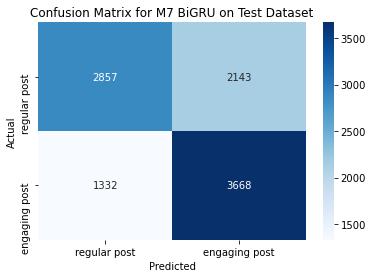

In [16]:
def calculate_classification_metrics(y_true, y_pred):
    """Calculate classification metrics."""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return accuracy, precision, recall, f1

def plot_confusion_matrix(y_true, y_pred, model_name):
    """Plot the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])  
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["regular post", "engaging post"], 
                yticklabels=["regular post", "engaging post"])
    plt.title(f"Confusion Matrix for {model_name} on Test Dataset")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def evaluate_model_classification(y_train_classification, y_test_classification, model=None, 
                                      predict_baseline=False, explainable=False, 
                                      lstm=False, features=None, model_name=None, 
                                      bert=False):
    """Evaluate model or baseline classification."""
    if predict_baseline:
        y_pred_train = [1] * len(y_train_classification)
        y_pred_test = [1] * len(y_test_classification)
    elif explainable:
        y_pred_train = model.predict(X_train[features])
        y_pred_test = model.predict(X_test[features])
        y_pred_train = (y_pred_train > 0.5).astype(int)
        y_pred_test = (y_pred_test > 0.5).astype(int)
        if hasattr(model, "feature_importances_"):
            plot_feature_importances(features, model.feature_importances_, model_name)
    elif lstm:
        y_pred_train = (model.predict([X_train_body, X_train_headline]) > 0.5).astype(int)
        y_pred_test = (model.predict([X_test_body, X_test_headline]) > 0.5).astype(int)
    elif bert:
        y_pred_train = (model.predict([X_train_body_ids_bert, X_train_body_mask_bert, 
                                       X_train_headline_ids_bert, X_train_headline_mask_bert]) > 0.5).astype(int)
        y_pred_test = (model.predict([X_test_body_ids_bert, X_test_body_mask_bert, 
                                      X_test_headline_ids_bert, X_test_headline_mask_bert]) > 0.5).astype(int)

    metrics_train = calculate_classification_metrics(y_train_classification, y_pred_train)
    metrics_test = calculate_classification_metrics(y_test_classification, y_pred_test)

    return metrics_train + metrics_test, y_pred_test

def create_evaluation_df_classification(model_name, metrics):
    """Create a DataFrame for model evaluation results."""
    return pd.DataFrame([{
        "Model": model_name, "Evaluation": "Train", "Accuracy": metrics[0], 
        "Precision": metrics[1], "Recall": metrics[2], "F1": metrics[3]
    }, {
        "Model": model_name, "Evaluation": "Test", "Accuracy": metrics[4], 
        "Precision": metrics[5], "Recall": metrics[6], "F1": metrics[7]
    }])

def train_bert_classification(model, X_train_body_ids_bert, X_train_body_mask_bert, 
                                  X_train_headline_ids_bert, X_train_headline_mask_bert, 
                                  y_train_classification):
    """
    Train the BERT model for binary classification with early stopping.
    """
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    
    history = model.fit(
        [X_train_body_ids_bert, X_train_body_mask_bert, X_train_headline_ids_bert, 
         X_train_headline_mask_bert], 
        y_train_classification,
        epochs=3,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping]
    )
    
    return model

def run_experiments(classification_models):
    evaluation_dfs_classification = []
    examples_df = pd.DataFrame(columns=["ModelName", "Type", "Example", "UpVotes", "DownVotes", 
                                        "article_post_count", "article_vote_count"])

    for model_name, model in classification_models.items():
        if "baseline" in model_name.lower():
            metrics, y_pred_test = evaluate_model_classification(y_train_classification, 
                                                                 y_test_classification,
                                                                 predict_baseline=True)

        elif any(i in model_name.lower() for i in ["knn", "decisiontree", "randomforest", "logistic"]):
            trained_model, feature_importances = train_explainable_model(model, 
                                                                         y_train_classification, 
                                                                         model_name,
                                                                         regression=False)
            metrics, y_pred_test = evaluate_model_classification(y_train_classification, y_test_classification, 
                                                                     model=trained_model, explainable=True,
                                                                     features=classification_models[model_name], 
                                                                     model_name=model_name)
        elif any(i in model_name.lower() for i in ["lstm", "gru"]):
            trained_model = train_lstm(model, X_train_body, X_train_headline, y_train_classification)
            metrics, y_pred_test = evaluate_model_classification(y_train_classification, y_test_classification, model=trained_model, lstm=True)

        elif "bert" in model_name.lower():
            trained_model = train_bert_classification(model, X_train_body_ids_bert, X_train_body_mask_bert, 
                                                         X_train_headline_ids_bert, X_train_headline_mask_bert, 
                                                         y_train_classification)
            metrics, y_pred_test = evaluate_model_classification(y_train_classification, y_test_classification, 
                                                                     model=trained_model, bert=True)

        evaluation_df = create_evaluation_df_classification(model_name, metrics)
        evaluation_dfs_classification.append(evaluation_df)

        plot_confusion_matrix(y_test_classification, y_pred_test, model_name)

        examples = {"True Positive": [], "True Negative": [], "False Positive": [], "False Negative": []}
        max_examples = 10  

        for i in range(len(y_test_classification)):
            example_data = {
                "ModelName": model_name,
                "Example": X_test.iloc[i]["FullText"],
                "UpVotes": y_test.iloc[i]["UpVotes"],
                "DownVotes": y_test.iloc[i]["DownVotes"],
                "article_post_count": 1,
                "article_vote_count": y_test.iloc[i]["article_vote_count"]
            }
            if y_test_classification.iloc[i] == 1 and y_pred_test[i] == 1:
                if len(examples["True Positive"]) < max_examples:
                    examples["True Positive"].append({**example_data, "Type": "True Positive"})
            elif y_test_classification.iloc[i] == 0 and y_pred_test[i] == 1:
                if len(examples["False Positive"]) < max_examples:
                    examples["False Positive"].append({**example_data, "Type": "False Positive"})
            elif y_test_classification.iloc[i] == 0 and y_pred_test[i] == 0:
                if len(examples["True Negative"]) < max_examples:
                    examples["True Negative"].append({**example_data, "Type": "True Negative"})                
            elif y_test_classification.iloc[i] == 1 and y_pred_test[i] == 0:
                if len(examples["False Negative"]) < max_examples:
                    examples["False Negative"].append({**example_data, "Type": "False Negative"})

        for example_type, example_list in examples.items():
            for example in example_list:
                examples_df = examples_df.append(example, ignore_index=True)

    evaluation_dfs_classification = pd.concat(evaluation_dfs_classification, ignore_index=True)
    evaluation_dfs_classification_sorted = evaluation_dfs_classification.sort_values(by="Evaluation", ascending=False)
    return evaluation_dfs_classification, examples_df
     
evaluation_dfs_classification, examples_df = run_experiments(classification_models)


In [17]:
evaluation_dfs_classification[evaluation_dfs_classification["Evaluation"] == "Test"]

,Model,Evaluation,Accuracy,Precision,Recall,F1
1,M7 BiGRU,Test,0.6525,0.631217,0.7336,0.678568


In [146]:
evaluation_dfs_classification[evaluation_dfs_classification["Evaluation"] == "Test"]

,Model,Evaluation,Accuracy,Precision,Recall,F1
1,Baseline Classification,Test,0.500159,0.500159,1.000000,0.666808
3,Logistic Regression,Test,0.603946,0.643347,0.467077,0.541221
5,M3 RandomForest CF + Sentiment,Test,0.646956,0.643910,0.658043,0.650899


In [145]:
evaluation_dfs_classification[evaluation_dfs_classification["Evaluation"] == "Test"]

,Model,Evaluation,Accuracy,Precision,Recall,F1
1,Baseline Classification,Test,0.500159,0.500159,1.000000,0.666808
3,Logistic Regression,Test,0.603946,0.643347,0.467077,0.541221
5,M3 RandomForest CF + Sentiment,Test,0.646956,0.643910,0.658043,0.650899


In [93]:
evaluation_dfs_classification[evaluation_dfs_classification["Evaluation"] == "Test"]

,Model,Evaluation,Accuracy,Precision,Recall,F1
1,Baseline Classification,Test,0.500000,0.500000,1.000000,0.666667
3,Logistic Regression,Test,0.603999,0.643201,0.467119,0.541198
5,M3 RandomForest CF + Sentiment,Test,0.646691,0.643286,0.658570,0.650839
7,M5 BiLSTM,Test,0.668487,0.682565,0.629932,0.655193


In [88]:
evaluation_dfs_classification[evaluation_dfs_classification["Evaluation"] == "Test"]

,Model,Evaluation,Accuracy,Precision,Recall,F1
1,Baseline Classification,Test,0.500000,0.500000,1.000000,0.666667
3,DecisionTree,Test,0.569368,0.570232,0.563216,0.566702
5,KNN,Test,0.594188,0.592461,0.603521,0.597940
7,M2 RandomForest Complex Features,Test,0.646691,0.643286,0.658570,0.650839
9,Logistic Regression,Test,0.603999,0.643201,0.467119,0.541198


In [72]:
evaluation_dfs_classification[evaluation_dfs_classification["Evaluation"] == "Test"]

,Model,Evaluation,Accuracy,Precision,Recall,F1
1,Baseline Classification,Test,0.5020,0.502000,1.000000,0.668442
3,DecisionTree,Test,0.5275,0.530406,0.512550,0.521325
5,KNN,Test,0.5393,0.541078,0.541833,0.541455
7,M1 RandomForest Shallow Features,Test,0.5370,0.536503,0.570916,0.553175
9,M2 RandomForest Complex Features,Test,0.5700,0.569391,0.588446,0.578762
11,Logistic Regression,Test,0.5660,0.589474,0.446215,0.507937
13,M3 RandomForest CF + Sentiment,Test,0.5700,0.569391,0.588446,0.578762
15,M4 LSTM,Test,0.5148,0.627660,0.082271,0.145474
17,M5 BiLSTM,Test,0.5836,0.593942,0.539044,0.565163
19,M6 BERT,Test,0.5809,0.576603,0.621514,0.598217


In [60]:
evaluation_dfs_classification[evaluation_dfs_classification["Evaluation"] == "Test"]

,Model,Evaluation,Accuracy,Precision,Recall,F1
1,Baseline Classification,Test,0.502,0.502000,1.000000,0.668442
3,Logistic Regression,Test,0.566,0.589474,0.446215,0.507937
5,M3 RandomForest CF + Sentiment,Test,0.570,0.569391,0.588446,0.578762


In [49]:
evaluation_dfs_classification[evaluation_dfs_classification["Evaluation"] == "Test"]

,Model,Evaluation,Accuracy,Precision,Recall,F1
1,Baseline Classification,Test,0.5006,0.500600,1.000000,0.667200
3,Logistic Regression,Test,0.5561,0.578293,0.418298,0.485453
5,M3 RandomForest CF + Sentiment,Test,0.5640,0.563037,0.576308,0.569595


In [23]:
evaluation_dfs_classification[evaluation_dfs_classification["Evaluation"] == "Test"]

,Model,Evaluation,Accuracy,Precision,Recall,F1
1,Baseline Classification,Test,0.5022,0.502200,1.000000,0.668619
3,DecisionTree,Test,0.5165,0.518885,0.511549,0.515191
5,KNN,Test,0.5231,0.525801,0.513341,0.519496
7,Logistic Regression,Test,0.5022,0.502200,1.000000,0.668619
9,M3 RandomForest CF + Sentiment,Test,0.5665,0.568990,0.564118,0.566543


In [234]:
evaluation_dfs_classification[evaluation_dfs_classification["Evaluation"] == "Test"]

,Model,Evaluation,Accuracy,Precision,Recall,F1
1,Baseline Classification,Test,0.5000,0.500000,1.0000,0.666667
3,DecisionTree,Test,0.5183,0.518601,0.5102,0.514366
5,KNN,Test,0.5212,0.521553,0.5130,0.517241
7,Logistic Regression,Test,0.5532,0.575913,0.4036,0.474600
9,M3 RandomForest CF + Sentiment,Test,0.5655,0.568414,0.5442,0.556044


In [223]:
evaluation_dfs_classification[evaluation_dfs_classification["Evaluation"] == "Test"]

,Model,Evaluation,Accuracy,Precision,Recall,F1
1,Baseline Classification,Test,0.4924,0.492400,1.000000,0.659877
3,DecisionTree,Test,0.5159,0.508471,0.505890,0.507177
5,KNN,Test,0.5303,0.523790,0.507514,0.515523
7,M2 RandomForest Complex Features,Test,0.5752,0.579120,0.502437,0.538060
9,Logistic Regression,Test,0.5517,0.582677,0.315597,0.409432
11,M3 RandomForest CF + Sentiment,Test,0.5752,0.579120,0.502437,0.538060
13,M4 LSTM,Test,0.5272,0.619512,0.103168,0.176880
15,M5 BiLSTM,Test,0.5787,0.569069,0.594842,0.581670
17,M6 BERT,Test,0.5747,0.559581,0.639927,0.597063


In [187]:
evaluation_dfs_classification[evaluation_dfs_classification["Evaluation"] == "Test"]

,Model,Evaluation,Accuracy,Precision,Recall,F1
1,Baseline Classification,Test,0.500000,0.500000,1.000000,0.666667
3,M5 BiLSTM,Test,0.596167,0.614077,0.517667,0.561765


In [216]:
evaluation_dfs_classification[evaluation_dfs_classification["Evaluation"] == "Test"]

,Model,Evaluation,Accuracy,Precision,Recall,F1
1,Baseline Classification,Test,0.55325,0.000000,0.000000,0.000000
3,DecisionTree,Test,0.56350,0.511233,0.522104,0.516611
5,KNN,Test,0.53175,0.474556,0.448797,0.461317
7,M1 RandomForest Shallow Features,Test,0.54300,0.489008,0.510353,0.499452
9,M2 RandomForest Complex Features,Test,0.63525,0.588745,0.608842,0.598624
11,M3 RandomForest CF + Sentiment,Test,0.63075,0.580394,0.626189,0.602423
13,M4 LSTM,Test,0.60825,0.560773,0.567991,0.564359
15,M5 BiLSTM,Test,0.63475,0.594878,0.571908,0.583167
17,M6 BERT,Test,0.63800,0.579991,0.687745,0.629288


In [78]:
evaluation_dfs_classification[evaluation_dfs_classification["Evaluation"] == "Test"]

,Model,Evaluation,Accuracy,Precision,Recall,F1
1,Baseline_Classification,Test,0.564,0.000000,0.000000,0.000000
3,Explainable_SimpleClassificationModel_RF,Test,0.550,0.485138,0.524083,0.503859


In [56]:
evaluation_dfs_classification[evaluation_dfs_classification["Evaluation"] == "Test"]

,Model,Evaluation,Accuracy,Precision,Recall,F1
1,Baseline_Classification,Test,0.552957,0.000000,0.00000,0.00000
3,Semi_Explainable_Classification_RF_BERT,Test,0.639490,0.590766,0.62993,0.60972


In [73]:
latex_table = tabulate(evaluation_dfs_classification[evaluation_dfs_classification["Evaluation"] == "Test"], 
                       headers="keys", tablefmt="latex", showindex=False, floatfmt=(".3f", ".3f", ".5f", ".5f"))

print(latex_table)

\begin{tabular}{llrrrr}
\hline
 Model                            & Evaluation   &   Accuracy &   Precision &    Recall &       F1 \\
\hline
 Baseline Classification          & Test         &    0.50200 &     0.50200 & 1         & 0.668442 \\
 DecisionTree                     & Test         &    0.52750 &     0.53041 & 0.51255   & 0.521325 \\
 KNN                              & Test         &    0.53930 &     0.54108 & 0.541833  & 0.541455 \\
 M1 RandomForest Shallow Features & Test         &    0.53700 &     0.53650 & 0.570916  & 0.553175 \\
 M2 RandomForest Complex Features & Test         &    0.57000 &     0.56939 & 0.588446  & 0.578762 \\
 Logistic Regression              & Test         &    0.56600 &     0.58947 & 0.446215  & 0.507937 \\
 M3 RandomForest CF + Sentiment   & Test         &    0.57000 &     0.56939 & 0.588446  & 0.578762 \\
 M4 LSTM                          & Test         &    0.51480 &     0.62766 & 0.0822709 & 0.145474 \\
 M5 BiLSTM                        & Test    

In [74]:
latex_table = tabulate(evaluation_dfs_classification[evaluation_dfs_classification["Evaluation"] == "Train"], 
                       headers="keys", tablefmt="latex", showindex=False, floatfmt=(".3f", ".3f", ".5f", ".5f"))

print(latex_table)

\begin{tabular}{llrrrr}
\hline
 Model                            & Evaluation   &   Accuracy &   Precision &    Recall &       F1 \\
\hline
 Baseline Classification          & Train        &    0.50197 &     0.50197 & 1         & 0.66842  \\
 DecisionTree                     & Train        &    0.94342 &     0.94845 & 0.938294  & 0.943344 \\
 KNN                              & Train        &    0.67105 &     0.67102 & 0.676229  & 0.673612 \\
 M1 RandomForest Shallow Features & Train        &    0.79148 &     0.79576 & 0.786444  & 0.791073 \\
 M2 RandomForest Complex Features & Train        &    0.88743 &     0.92730 & 0.841725  & 0.882444 \\
 Logistic Regression              & Train        &    0.55432 &     0.57546 & 0.427661  & 0.490672 \\
 M3 RandomForest CF + Sentiment   & Train        &    0.88743 &     0.92730 & 0.841725  & 0.882444 \\
 M4 LSTM                          & Train        &    0.51618 &     0.62272 & 0.0917376 & 0.159917 \\
 M5 BiLSTM                        & Train   

In [150]:
examples_df

,ModelName,Type,Example,UpVotes,DownVotes,article_post_count,article_vote_count
87,Baseline Classification,False Positive,"die ""politik"" und ""die religion"" haben sich im...",0,0,1,7806
34,Baseline Classification,True Positive,"ich kaufe das halal fleisch sicher nicht , ega...",12,2,1,9955
32,Baseline Classification,False Positive,"Ich denke, ich verstehe ihre Ansicht recht gut...",0,0,1,152
40,Baseline Classification,False Positive,"na dann, viel Spaß in Deiner Welt",0,0,1,4816
42,Baseline Classification,True Positive,Was ist da naturgemäss?\r\nDas nicht nachgedac...,20,5,1,15131
...,...,...,...,...,...,...,...
55,M3 RandomForest CF + Sentiment,False Negative,Bester Stürmer: Lionel Messi\r\nBester La Liga...,25,0,1,165
57,M3 RandomForest CF + Sentiment,False Negative,Oide!,73,0,1,9732
63,M3 RandomForest CF + Sentiment,False Positive,Wo kann ich bitte mehr Informationen finden üb...,2,0,1,394
26,M3 RandomForest CF + Sentiment,False Positive,"""Derzeit befinden sich nur zwei Schubhäftlinge...",1,14,1,622


In [220]:
examples_df[(examples_df["ModelName"] == "Explainable_ComplexClassificationModel_RF") & 
            (examples_df["Type"].str.startswith("False") )][["Type", "Example", 
                                                             "UpVotes", "DownVotes"]].sort_values("Type").style

,Type,Example,PositiveVotes,NegativeVotes


In [22]:
df_merged[df_merged["FullText"].str.contains("soll amnesty sch")][["FullText", "PostEngagement"]]

,FullText,Post_Engagement


In [23]:
df_merged[df_merged["FullText"].str.contains("soll amnesty sch")][["FullText", "PostEngagement"]]

,FullText,Post_Engagement


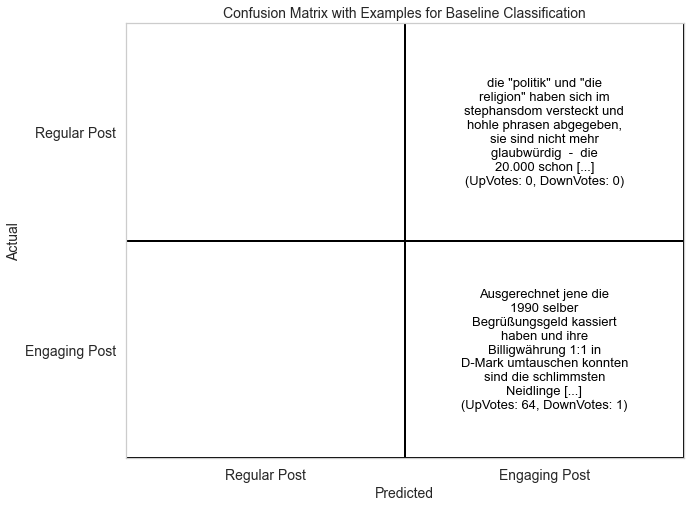

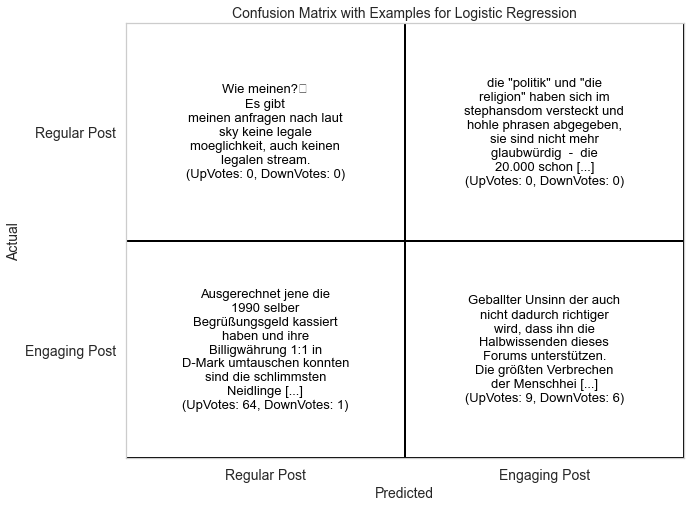

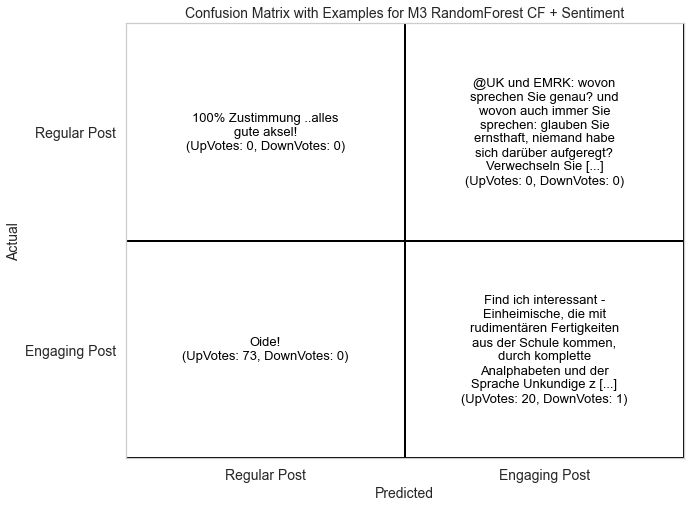

In [172]:
# Shuffle the examples_df
examples_df = examples_df.sample(frac=1).reset_index(drop=True).sort_values(by="ModelName")

def format_example_text(example_text, pos_votes, neg_votes, article_post_count, article_vote_count):
    """
    Format example text to display only the first 150 characters with line breaks every 25 characters,
    without cutting words. Add '...' at the end if the text is truncated.
    """
    if example_text:
        # Limit to 150 characters
        truncated_text = example_text[:150]
        # Check if truncation occurred and append ellipsis if needed
        if len(example_text) > 150:
            truncated_text = truncated_text.rstrip() + " [...]"
        # Wrap text without splitting words
        wrapped_text = textwrap.fill(truncated_text, width=25, break_long_words=False, replace_whitespace=False)
        return f"{wrapped_text}\n(UpVotes: {pos_votes}, DownVotes: {neg_votes})"
    return "No Example"

def plot_confusion_matrix_of_examples(examples_df, model_name):
    """Plot the confusion matrix using the examples dataframe."""
    labels = ["Regular Post", "Engaging Post"]
    cm = [[0, 0], [0, 0]]  # Initialize confusion matrix counts

    # Fill confusion matrix based on examples_df
    for _, row in examples_df.iterrows():
        if row["Type"] == "True Positive":
            cm[1][1] += 1
        elif row["Type"] == "True Negative":
            cm[0][0] += 1
        elif row["Type"] == "False Positive":
            cm[0][1] += 1 
        elif row["Type"] == "False Negative":
            cm[1][0] += 1

    plt.figure(figsize=(10, 8))  # Increase the overall size

    # Create a grid for the confusion matrix
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            # Draw rectangle for each cell
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor="black", lw=2))
            # Only annotate if there"s a count
            if cm[i][j] > 0:
                # Find the corresponding example
                example_row = examples_df[(examples_df["Type"] == ("True Positive" if i == 1 and j == 1 else
                                                                    "True Negative" if i == 0 and j == 0 else
                                                                    "False Positive" if i == 0 and j == 1 else
                                                                    "False Negative"))]
                
                # Fetch the corresponding example text
                if not example_row.empty:
                    example = example_row.iloc[0]
                    formatted_text = format_example_text(example["Example"], 
                                                          example["UpVotes"], 
                                                          example["DownVotes"],
                                                          example["article_post_count"],
                                                          example["article_vote_count"])
                else:
                    formatted_text = "No Example"
                    
                # Place the text in the center of each cell
                plt.text(j + 0.5, i + 0.5, formatted_text, ha="center", va="center", 
                         fontsize=13, color="black")

    # Set axis limits and labels
    plt.xlim(0, len(cm[0]))
    plt.ylim(0, len(cm))
    plt.title(f"Confusion Matrix with Examples for {model_name}", fontsize=14)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("Actual", fontsize=14)
    plt.xticks([0.5, 1.5], labels, fontsize=14)
    plt.yticks([0.5, 1.5], labels, fontsize=14)
    plt.gca().invert_yaxis()  # Invert y axis to have the origin in the top left

    plt.grid(False)  # Disable the grid
    plt.axis("on")  # Show the axes
    plt.savefig(f'./figures/quantitive_confusion_matrix_{model_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Example call to plot the confusion matrix using examples_df
for model_name in examples_df["ModelName"].unique():
    model_examples_df = examples_df[examples_df["ModelName"] == model_name]
    plot_confusion_matrix_of_examples(model_examples_df, model_name)


In [162]:
df_merged[df_merged['FullText'] == 'stets :-)'][['FullText', 'IsReply', 'UpVotes']].style

,FullText,IsReply,UpVotes
329550,stets :-),1,11


In [25]:
examples_df.columns

Index(['ModelName', 'Type', 'Example', 'PositiveVotes', 'NegativeVotes',
       'article_post_count', 'article_vote_count'],
      dtype='object')

In [26]:
examples_df[examples_df["Example"].str.contains("niemand verteidigt menschen")]

,ModelName,Type,Example,PositiveVotes,NegativeVotes,article_post_count,article_vote_count


In [210]:
df_merged[df_merged["FullText"].str.contains("niemand verteidigt menschen")][["FullText", "PostEngagement"]]

,FullText,Post_Engagement
11,niemand verteidigt menschen die gegen unsere g...,regular post


In [202]:
df_merged[df_merged["FullText"].str.contains("Bin kein Fan von Schützen")][["FullText", "PostEngagement"]]

,FullText,Post_Engagement
7,"Bin kein Fan von Schützenhöfer, aber was Sie d...",top post


In [231]:
df_merged[(df_merged["PostEngagement"] == "engaging post") & (df_merged["Totalvotes"] == 0) ].head(5)

,ID_Post,ID_Article,ID_User,CreatedAt,Status,Headline,Body,PositiveVotes,NegativeVotes,Path,...,past_tense_frequency,desire_frequency,gratitude_word_frequency,sweat_word_frequency,formality_word_frequency,link_to_text_ratio,digits_to_text_ratio,publication_time,publication_rank,sentiment_score


### Step 3.2: Regression Task

In [196]:
regression_models = {
    "Baseline_Regression": y_train_regression.mean(), 
    #"Explainable_SimpleRegressionModel_RF": ["word_count", "punctuation_count",
     #                       "unique_words", "title_length", "body_length",
      #                     "title_to_body_ratio", "character_count"],
    "Explainable_ComplexRegressionModel_RF": generated_features_wo_sentiment,
    "Semi_Explainable_ComplexRegression_RF_BERT": generated_features
}

In [ ]:
# Define hyperparameters
embedding_dim = 64
lstm_units = 64
dropout_rate = 0.3

# Textual input: Body
input_body = Input(shape=(max_len,), name="body_input")
embedding_body = Embedding(input_dim=len(body_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_body)
lstm_body = LSTM(lstm_units, return_sequences=False)(embedding_body)
dropout_body = Dropout(dropout_rate)(lstm_body)

# Textual input: Headline
input_headline = Input(shape=(max_len,), name="headline_input")
embedding_headline = Embedding(input_dim=len(headline_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_headline)
lstm_headline = LSTM(lstm_units, return_sequences=False)(embedding_headline)
dropout_headline = Dropout(dropout_rate)(lstm_headline)

# Temporal features input
input_temporal = Input(shape=(2,), name="temporal_input")

# Concatenate all inputs
concatenated = concatenate([dropout_body, dropout_headline, input_temporal])

# Add batch normalization for stability
batch_norm = BatchNormalization()(concatenated)

# Output layer with linear activation for regression
output = Dense(1, activation="linear")(batch_norm)

# Define the model
model = Model(inputs=[input_body, input_headline, input_temporal], outputs=output)

# Compile the model with a regression loss function
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Summary of the model
model.summary()

# Add the model to the regression models dictionary
regression_models["LSTM_Regression_Model"] = model

In [ ]:
# Define hyperparameters
embedding_dim = 64
lstm_units = 64
dropout_rate = 0.3

# Textual input: Body
input_body = Input(shape=(max_len,), name="body_input")
embedding_body = Embedding(input_dim=len(body_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_body)
# Use Bidirectional LSTM
bi_lstm_body = Bidirectional(LSTM(lstm_units, return_sequences=False))(embedding_body)
dropout_body = Dropout(dropout_rate)(bi_lstm_body)

# Textual input: Headline
input_headline = Input(shape=(max_len,), name="headline_input")
embedding_headline = Embedding(input_dim=len(headline_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_headline)
# Use Bidirectional LSTM
bi_lstm_headline = Bidirectional(LSTM(lstm_units, return_sequences=False))(embedding_headline)
dropout_headline = Dropout(dropout_rate)(bi_lstm_headline)

# Temporal features input
input_temporal = Input(shape=(2,), name="temporal_input")

# Concatenate all inputs
concatenated = concatenate([dropout_body, dropout_headline, input_temporal])

# Add batch normalization for stability
batch_norm = BatchNormalization()(concatenated)

# Output layer with linear activation for regression
output = Dense(1, activation="linear")(batch_norm)

# Define the model
model = Model(inputs=[input_body, input_headline, input_temporal], outputs=output)

# Compile the model with a regression loss function
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Summary of the model
model.summary()

# Add the model to the regression models dictionary
regression_models["BiLSTM_Regression_Model"] = model

In [ ]:
def calculate_regression_metrics(y_true, y_pred):
    """Calculate regression metrics."""
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

# Updated evaluate_model_regression function to include feature importance plotting
def evaluate_model_regression(y_train_regression, y_test_regression, model=None, 
                              predict_baseline=False, explainable=False, lstm=False, 
                              features=None, model_name=None):
    """Evaluate model or baseline regression."""
    if predict_baseline:
        y_pred_train = [y_train_regression.mean()] * len(y_train_regression)
        y_pred_test = [y_train_regression.mean()] * len(y_test_regression)
    elif explainable:
        y_pred_train = model.predict(X_train[features])
        y_pred_test = model.predict(X_test[features])
        
        # Plot feature importances after training RandomForest
        plot_feature_importances(features, model.feature_importances_, model_name)
        
    elif lstm:
        y_pred_train = model.predict([X_train_body, X_train_headline, X_train_temporal])
        y_pred_test = model.predict([X_test_body, X_test_headline, X_test_temporal])
    
    metrics_train = calculate_regression_metrics(y_train_regression, y_pred_train)
    metrics_test = calculate_regression_metrics(y_test_regression, y_pred_test)
    
    return metrics_train + metrics_test, y_pred_test

def create_evaluation_df_regression(model_name, metrics):
    """Create a DataFrame for model evaluation results."""
    return pd.DataFrame([
        {'Model': model_name, 'Evaluation': 'Train', 'MSE': metrics[0], 'MAE': metrics[1], 'R2': metrics[2]},
        {'Model': model_name, 'Evaluation': 'Test', 'MSE': metrics[3], 'MAE': metrics[4], 'R2': metrics[5]}
    ])

# Evaluate each model
evaluation_regression_dfs = []

for model_name, X_baseline in regression_models.items():
    if 'baseline' in model_name.lower():
        metrics, y_pred_test = evaluate_model_regression(y_train_regression, y_test_regression, 
                                                         predict_baseline=True)

    elif 'explainable' in model_name.lower():
        trained_model, feature_importances = train_explainable_model(regression_models[model_name], y_train_regression)
        metrics, y_pred_test = evaluate_model_regression(y_train_regression, y_test_regression, 
                                                         model=trained_model, explainable=True,
                                                         features=regression_models[model_name], 
                                                         model_name=model_name)
    elif 'lstm' in model_name.lower():
        model = regression_models[model_name]
        trained_model = train_lstm(model, X_train_body, X_train_headline, 
                                              X_train_temporal, y_train_regression)
        metrics, y_pred_test = evaluate_model_regression(y_train_regression, y_test_regression, model=model, lstm=True)
        
    # Save results
    evaluation_df = create_evaluation_df_regression(model_name, metrics)
    evaluation_regression_dfs.append(evaluation_df)

# Combine evaluation results into one DataFrame
evaluation_regression_dfs = pd.concat(evaluation_regression_dfs, ignore_index=True)
evaluation_regression_dfs_sorted = evaluation_regression_dfs.sort_values(by='Evaluation', ascending=False)

In [196]:
evaluation_regression_dfs_sorted[evaluation_regression_dfs_sorted["Evaluation"] == "Test"]

,Model,Evaluation,MSE,MAE,R2
1,Baseline_Regression,Test,138.674978,6.647714,-0.000195
3,Explainable_ComplexRegressionModel_RF,Test,133.174658,6.321218,0.039476
5,Semi_Explainable_ComplexRegression_RF_BERT,Test,133.494985,6.326507,0.037166
7,LSTM_Regression_Model,Test,137.317011,6.437880,0.009600
9,BiLSTM_Regression_Model,Test,135.478832,6.361866,0.022858


In [106]:
evaluation_regression_dfs_sorted[evaluation_regression_dfs_sorted["Evaluation"] == "Test"]

,Model,Evaluation,MSE,MAE,R2
1,Baseline_Regression,Test,1.356177,0.809255,-0.000293
3,Explainable_ComplexRegressionModel_RF,Test,1.292676,0.769878,0.046544
5,Semi_Explainable_ComplexRegression_RF_BERT,Test,1.292405,0.769785,0.046744
7,LSTM_Regression_Model,Test,1.342567,0.785014,0.009745
9,BiLSTM_Regression_Model,Test,1.321897,0.778484,0.024992


In [107]:
X_train[["FullText", "Headline"]].head(100).style

,FullText,Headline
0,"Flüchtlinge aufnehmen Jeder der sich hier aufregt über die furchtbaren Zustände in Traiskirchen, hat ja die Möglichkeit Flüchtlinge in seiner Wohnung aufzunehmen.",Flüchtlinge aufnehmen
1,"Frage: Wer soll denn das bezahlen? Welche Organisation soll das durchsetzen? Die UNO? Ich wünsche mir auch sehr viel, und es gibt ganz viele ganz großartige Ideen. Umsetzbar sollten sie schon auch sein. In Ö scheitert es schon daran im Monat ein paar Euro pro Person dezidiert an Flüchtlingshilfe politisch durchzusetzen, die Milliarden für einen Bodeneinsatz in Syrien sollen woher kommen?",
2,"Das les ich jetzt schon zum 2. Mal. Und lassens die Hunde und Katzerln, machen mögen das halt, basta. Die mögen die Tier sogar lieber als die Menschen und warum sollten die dann Freudenluftsprünge wegen der Flüchtlinge machen?",
3,"Ach das wird sicher ""Lustig""!!!",
4,"Dabei besteht ja neben den Exporten der wirtschaftliche Teil des deutschen Erfolges aus Missverständnissen. Die deutschen Automilliardäre werden mit staatlicher Hilfe noch reicher (lassen sich 1 €-Jobber vom Staat mitfinanzieren, die Löhne wurde im Vergleich zur Inflation und zu den Gewinnen der Konzerne viel zu wenig erhöht, Hartz-IV ist in manchen Fällen viel zu wenig, etc...) Amazon und Zalando werden enorm staatlich subventioniert (die Versendezentren), etc. Die Liste kann weitergeführt werden.... Die deutsche Infrastruktur (Brücken, Autostrassen, etc...) zerfällt schön langsam. Also wahrscheinlich noch besser als der Rest, aber sonst?)",Dabei besteht ja neben den Exporten der wirtschaftliche Teil des deutschen Erfolges aus Missverständnissen.
5,"Langsam gehen die Augen in Europa auf, aber nur sehr langsam...",
6,"Kann man das jetzt als Fakt behaupten ""Österreich gibt Geld für irrationales unnötiges und sinnloses aus um irrationales braunes ""Bauchgefühl"" zu beruhigen?","Kann man das jetzt als Fakt behaupten ""Österreich gibt Geld für irrationales unnötiges und sinnloses aus um irrationales braunes ""Bauchgefühl"" zu beruhigen?"
7,Ich weiß nicht ob man jemanden der keine Ahnung hat was die Voraussetzungen sind für den Erhalt der Mindestsicherung (hint ein abgelehnter Asylbescheid ist das nicht) mit Prozentangaben trauen sollte...,
8,"Bevölkerungsexplosion 1960 hatte Syrien 2,7 Mio Ew., Irak 8 Mio, Ägypten 20 Mio, Libyen 1,5 Mio 2012 hatte Syrien 23 Mio Ew., Irak 37 Mio, Ägypten 88 Mio, Libyen 6 Mio. Nordafrika wurde u. a. durch Überbevölkerung destabilisiert. Warum sollten sich die Flüchtlinge in Europa nicht ebenso vermehren? Mohammed sagte: Ich werde die Welt durch die Gebärmutter der Frauen erobern!",Bevölkerungsexplosion
9,"legale Wege und de facto Obergrenzen Die humanistischen Führer und Denker in Europa, welche immer wieder Obergrenzen ablehnen, könnten das Sterben im Mittelmeer sehr rasch beenden und die Schlepper arbeitslos machen... sie müssten nur den ""Visa-Zwang"" für z. B. Syrer aufheben. Auf einen Schlag könnten Sie für 50€ von Antalya nach Wien fliegen, anstatt mehere tausend € für Schlepper bezahlen zu müssen. Wieso forderen das nicht einmal die Linken? .. weil die Personengruppe, die sich 50€ leisten kann nunmal sehr viel größer ist, als die die sich tausende € für Schlepper leisten können.. stillschweigende Akzeptanz? ...nun zu meiner Frage an alle ""Obergrenzen-Verweigerer"": Ist diese de facto Begrenzung nun menschenrechtskonformer als eine staatlich festgelegte Obergrenze??",legale Wege und de facto Obergrenzen


In [108]:
X_train.columns

Index(['ID_Post', 'ID_Article', 'ID_User', 'CreatedAt', 'Status', 'Headline',
       'Body', 'Path', 'publishingDate', 'Title',
       ...
       'ngram_ernst nehmen', 'ngram_leute nicht', 'ngram_türkei eu',
       'ngram_glaube nicht', 'ngram_er recht', 'ngram_viele menschen',
       'ngram_nicht will', 'ngram_nicht funktioniert', 'ngram_überhaupt nicht',
       'ngram_europa nicht'],
      dtype='object', length=411)

In [109]:

latex_table = tabulate(evaluation_regression_dfs_sorted[evaluation_regression_dfs_sorted["Evaluation"] == "Test"], 
                       headers="keys", tablefmt="latex", showindex=False, floatfmt=(".3f", ".3f", ".5f", ".5f"))

print(latex_table)

\begin{tabular}{llrrr}
\hline
 Model                                      & Evaluation   &     MSE &     MAE &           R2 \\
\hline
 Baseline\_Regression                        & Test         & 1.35618 & 0.80925 & -0.000293192 \\
 Explainable\_ComplexRegressionModel\_RF      & Test         & 1.29268 & 0.76988 &  0.0465441   \\
 Semi\_Explainable\_ComplexRegression\_RF\_BERT & Test         & 1.29240 & 0.76979 &  0.0467443   \\
 LSTM\_Regression\_Model                      & Test         & 1.34257 & 0.78501 &  0.00974544  \\
 BiLSTM\_Regression\_Model                    & Test         & 1.32190 & 0.77848 &  0.0249916   \\
\hline
\end{tabular}
